<a href="https://colab.research.google.com/github/dndpd/MachineLearning/blob/main/CV_week_2_%EC%86%90%EC%84%B1%ED%98%B8_20201773.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 실습 환경설정

In [1]:
# 학번, 이름 화면에 출력
id = '20201773'
name = '손성호'
print(id, name)

20201773 손성호


In [2]:
# 구글 드라이브 사용 권한 설정
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
# 과제 파일 저장한 폴더 위치 설정 (폴더 위치에 맞춰서 변경할 것)
import os
colab_path = "/gdrive/My Drive/Colab Notebooks/CV_week_2"  # 경로예시: 구글드라이브/내 드라이브/Colab Notebooks/과제폴더명

In [4]:
!pip install jpegio  # jpeg DCT 계수, 양자화 테이블값 획득하기 위한 패키지 설치

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.0 MB/s eta 0:00:00


In [5]:
import jpegio
import numpy as np
from scipy import fftpack
import cv2
import matplotlib.pyplot as plt

# JPEG 실습내용

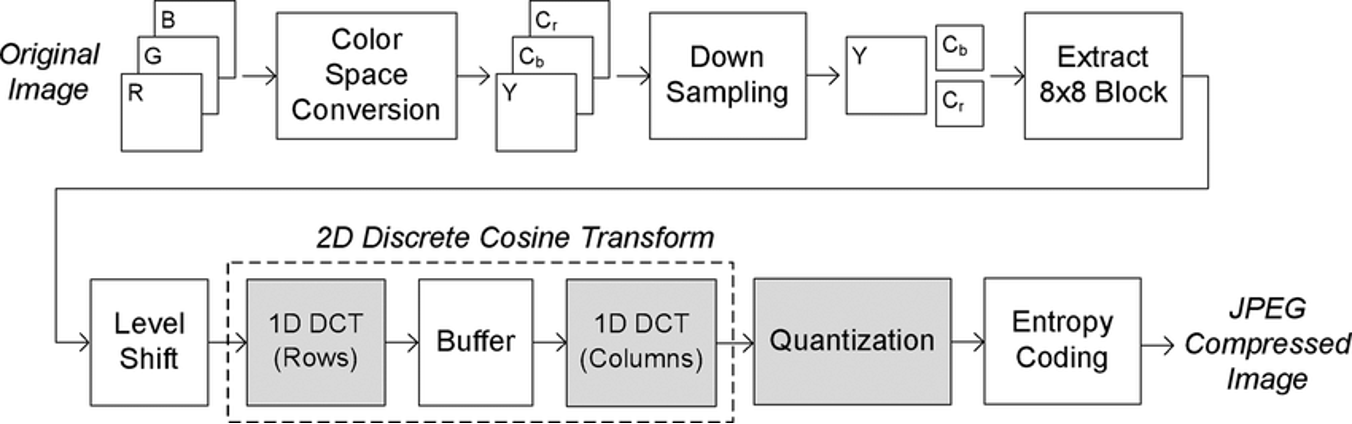

## JPEG 관련 함수 정의

In [6]:
def idct2d(f):
    x1 = fftpack.idct(f, norm="ortho")
    x2 = fftpack.idct(x1.transpose((0, 1, 2, 4, 3)), norm="ortho")
    return x2.transpose((0, 1, 2, 4, 3))

In [7]:
def ycbcr2rgb(im):
    """
    im: numpy array H x W x C, range [0, 255]
    C: [Y, Cb, Cr]
    output: numpy array H x W x C, range [0, 255]
    """
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = im.astype(np.float64)
    rgb = rgb.dot(xform.T)
    return np.array(rgb, dtype=im.dtype)

In [8]:
def jpg444recon(path):
    image = jpegio.read(path)
    image.quant_tables.append(image.quant_tables[1])  # Cr 양자화 테이블 채널 추가(Cb와 동일)
    coef_arrays = image.coef_arrays  # YCbCr 양자화된 DCT 계수
    quant_tables = image.quant_tables  # YCbCr 양자화 테이블
    h, w = coef_arrays[0].shape
    image_q = np.array(quant_tables).astype(np.int16).reshape((-1, 1, 1, 8, 8))
    image_c = np.array(coef_arrays)
    image_c = image_c.reshape((3, h // 8, 8, w // 8, 8), order='C').transpose(0, 1, 3, 2, 4)  # 8x8 block 단위로 채널 분리
    deq = image_c * image_q  # 양자화 복원: 양자화된 계수 * 양자화 테이블
    image_ycbcr = idct2d(deq).transpose(0, 1, 3, 2, 4).reshape(3, h, w)  # Inverse DCT2D 수행
    image_ycbcr = image_ycbcr.transpose(1, 2, 0)  # 채널 변경: CxHwW -> HxWxC
    image_ycbcr[:, :, 0] += 128  # 밝기 Level Shift 복원 (128 더하기)
    image_rgb = np.clip(ycbcr2rgb(image_ycbcr), 0, 255)  # RGB 픽셀값 범위로 값 절삭
    image_rgb = image_rgb.astype(np.uint8)  # UINT8로 타입 변환 (값 범위 0~255)

    return image_rgb

In [9]:
img_color_cv = cv2.imread(os.path.join(colab_path, '00016.jpeg'), cv2.IMREAD_COLOR)  # OpenCV로 Color 이미지 읽기

In [10]:
img_color_cv.dtype  # uint8: 정수형 [0, 255]

dtype('uint8')

In [11]:
img_color_cv.shape  # 이미지 크기 확인

(512, 512, 3)

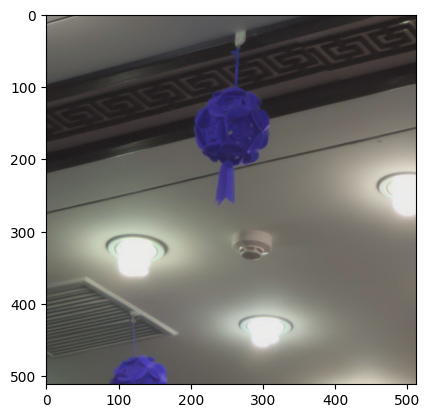

In [12]:
plt.imshow(img_color_cv)  # 이미지 화면 출력, OpenCV 기본 컬러순서: B, G, R

In [13]:
img_color_cv = cv2.cvtColor(img_color_cv, cv2.COLOR_BGR2RGB)  # 컬러 채널 순서 변경: BGR -> RGB

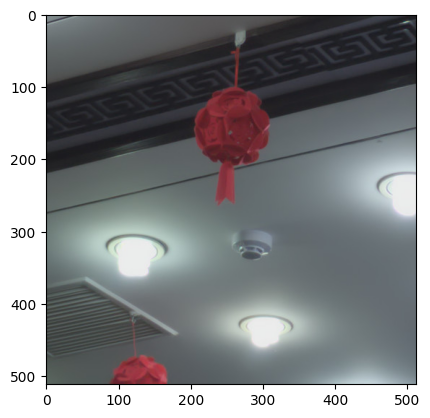

In [14]:
plt.imshow(img_color_cv)  # 이미지 화면 출력

In [15]:
img_color_recon = jpg444recon(os.path.join(colab_path, '00016.jpeg'))  # jpegio로 JPEG 이미지 읽어서 RGB 픽셀값 복원하기

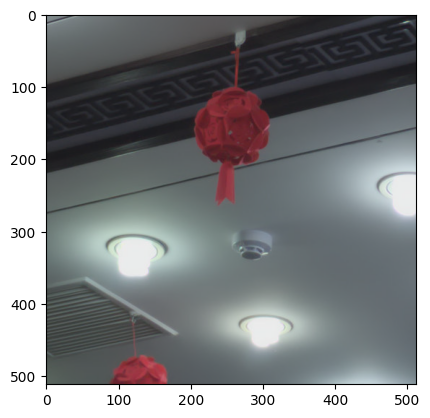

In [16]:
plt.imshow(img_color_recon)  # 이미지 화면 출력

# 실습 과제

JPEG 압축은 압축효율을 위해 YUV420 포맷을 기본값으로 사용함

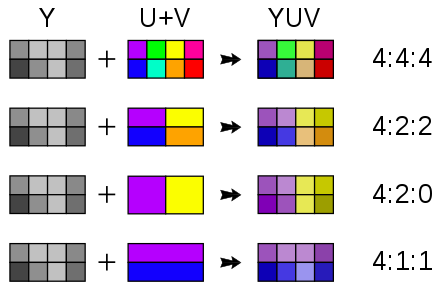

문제: YUV420으로 압축한 JPEG 이미지의 픽셀값을 복원하는 함수를 작성하시오.
- YUV420: 압축 효율을 위해 색상값(Cb, Cr)을 가로 1/2배, 세로 1/2배로 subsampling한 이미지 형식
- jpeg444recon 함수 참고할 것
- OpenCV 등 다른 영상처리 패키지 사용 불가
- 힌트: Y, Cb, Cr채널 별로 픽셀값 복원 -> Y채널 크기에 맞도록 Cb, Cr 크기 조절(cv2.resize) -> YCbCr 3개 채널로 합치기 -> RGB 포맷으로 바꾸기

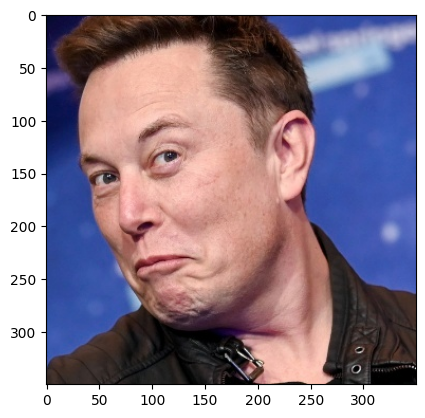

In [41]:
img_color_cv = cv2.imread(os.path.join(colab_path, 'elon-face.jpg'), cv2.IMREAD_COLOR)  # OpenCV로 Color 이미지 읽기
img_color_cv = cv2.cvtColor(img_color_cv, cv2.COLOR_BGR2RGB)  # 컬러 채널 순서 변경: BGR -> RGB
plt.imshow(img_color_cv)  # 이미지 화면 출력

In [24]:
img_color_cv.dtype

dtype('uint8')

In [25]:
img_color_cv.shape

(350, 350, 3)

In [117]:
img_color_cv=cv2.resize(img_color_cv,(512,512))

In [118]:
def jpg420recon(path):
    image = jpegio.read(path)
    # 코드 작성 부분
    image.quant_tables.append(image.quant_tables[1])  # Cr 양자화 테이블 채널 추가(Cb와 동일)
    coef_arrays = image.coef_arrays  # YCbCr 양자화된 DCT 계수
    quant_tables = image.quant_tables  # YCbCr 양자화 테이블
    h, w = coef_arrays[0].shape
    image_q = np.array(quant_tables).astype(np.int16).reshape((-1, 1, 1, 8, 8))
    image_c = np.array(coef_arrays)
    image_c = image_c.reshape((3, h // 8, 8, w // 8, 8)).transpose(0, 1, 3, 2, 4)
    deq = image_c * image_q  # 양자화 복원: 양자화된 계수 * 양자화 테이블
    image_ycbcr = idct2d(deq).transpose(0, 1, 3, 2, 4).reshape(3, h, w)  # Inverse DCT2D 수행
    image_ycbcr = image_ycbcr.transpose(1, 2, 0)  # 채널 변경: CxHxW -> HxWxC
    image_ycbcr[:, :, 0] += 128  # 밝기 Level Shift 복원 (128 더하기)
    image_rgb = np.clip(ycbcr2rgb(image_ycbcr), 0, 255)  # RGB 픽셀값 범위로 값 절삭
    image_rgb = image_rgb.astype(np.uint8)  # UINT8로 타입 변환 (값 범위 0~255)
    return image_rgb



In [119]:
# 코드 결과 확인 부분: 수정하지 말 것
img_color_recon420 = jpg420recon(os.path.join(colab_path, 'elon-face.jpg'))  # jpegio로 JPEG 이미지 읽어서 RGB 픽셀값 복원하기

plt.imshow(img_color_recon420)  # 이미지 화면 출력

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.